In [ ]:
import torch
import torchvision
from torchvision import datasets
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda, ToPILImage
from torch.utils.data import DataLoader, Subset

from torch import nn, optim
from torch.nn import functional as F

import numpy as np
import matplotlib.pyplot as plt



In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
class Downsample(nn.Module):
  def __init__(self, in_features, out_features, kernel_size=2):
    super().__init__()
    self.layer = nn.Sequential(
        nn.MaxPool2d(kernel_size),
        nn.Conv2d(in_features, out_features, 3, padding="same"),
        nn.BatchNorm2d(out_features),
        nn.LeakyReLU(0.1),
    )

  def forward(self, x):
    return self.layer(x)

class Upsample(nn.Module):

  def __init__(self, in_features, out_features, factor=2):
    super().__init__()
    self.layer = nn.Sequential(
        nn.Upsample(scale_factor=factor),
        nn.Conv2d(in_features, out_features, 3, padding="same"),
        nn.BatchNorm2d(out_features),
        nn.LeakyReLU(0.1),
    )

  def forward(self, x):
    return self.layer(x)

class Block(nn.Module):
  def __init__(self, in_features, out_features, num_layers):
    super().__init__()
    layers = []
    for i in range(num_layers):
      if i == 0:
        layers.append(
            nn.Sequential(
                nn.Conv2d(in_features, out_features, 3, padding="same"),
                nn.BatchNorm2d(out_features),
                nn.LeakyReLU(0.1)
                )
            )

      else:
        layers.append(
            nn.Sequential(
                nn.Conv2d(out_features, out_features, 3, padding="same"),
                nn.BatchNorm2d(out_features),
                nn.LeakyReLU(0.1)
            )
      )

    self.layer = nn.Sequential(*layers)

  def forward(self, x):
    return self.layer(x)

class UNet(nn.Module):
  def __init__(self):
    super().__init__()

    self.blk_1 = Block(3, 32, 4)
    self.ds_1 = Downsample(32, 64)

    self.blk_2 = Block(64, 64, 4)
    self.ds_2 = Downsample(64, 128)

    self.blk_3 = Block(128, 128, 4)
    self.us_1 = Upsample(128, 64)

    self.blk_4 = Block(128, 64, 4)
    self.us_2 = Upsample(64, 32)

    self.blk_5 = Block(64, 32, 4)
    self.blk_6 = nn.Sequential(
        nn.Conv2d(32, 3, 3, padding="same"),
        # nn.BatchNorm2d(3),
        nn.Tanh(),
    )

  def forward(self, x, t):
    device = x.device
    batches = x.shape[0]
    blocks = []
    t_ = torch.linspace(0, 1, x.shape[2], device=device).repeat(batches, x.shape[1], x.shape[2], 1)
    t_ = torch.sin(t*10000**(2*t_))
    x = nn.functional.layer_norm(x + t_, normalized_shape=x.shape)
    x = self.blk_1(x)
    blocks.append(x)
    x = self.ds_1(x)

    x = self.blk_2(x)
    blocks.append(x)
    x = self.ds_2(x)

    x = self.blk_3(x)
    x = self.us_1(x)
    x = torch.cat([blocks.pop(), x], dim=1)

    x = self.blk_4(x)
    x = self.us_2(x)
    x = torch.cat([blocks.pop(), x], dim=1)
    x = self.blk_5(x)

    x = self.blk_6(x)
    return x

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!kaggle datasets download -d ashishjangra27/gender-recognition-200k-images-celeba
!unzip /content/gender-recognition-200k-images-celeba.zip


In [ ]:
from torchvision.transforms import Resize, CenterCrop

dataset = datasets.CIFAR10(
    # root="Dataset/Train",
    root="datasets/",
    download=True,
    transform=Compose([
        ToTensor(),
        Resize((32, 32)),
        CenterCrop((32, 32)),
        Lambda(lambda x: x*2 - 1),
    ])
)

dataset = Subset(dataset, list(range(500)))

loader = DataLoader(dataset, batch_size=32, shuffle=True)
x_test, _ = next(iter(loader))
x_test.shape


Files already downloaded and verified


torch.Size([32, 3, 32, 32])

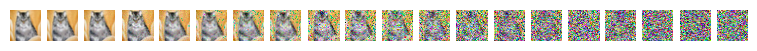

In [ ]:
class NoiseSchedular:
  def __init__(self, num_time_steps, start_beta, end_beta, device=torch.device("cpu")):
    self.num_time_steps = num_time_steps
    self.start_beta = start_beta
    self.end_beta = end_beta
    self.device = device

    self.beta = torch.linspace(start_beta, end_beta, num_time_steps, device=device)
    self.beta = self.beta*self.beta
    self.alpha = 1 - self.beta
    self.alpha_cumprod = self.alpha.cumprod(dim=0)

  def add_noise(self, image, time_step):
    alpha_cumprod = self.alpha_cumprod[time_step]
    sqrt_cumprod = torch.sqrt(alpha_cumprod)
    one_minus_sqrt_cumprod = torch.sqrt(1 - alpha_cumprod)
    noise = torch.randn_like(image).to(self.device)
    noisy_image = sqrt_cumprod*image + one_minus_sqrt_cumprod*noise
    return noisy_image, noise


noise_schedular = NoiseSchedular(
    num_time_steps=1000,
    start_beta=0.0001,
    end_beta = 0.05,
    device=device
)

fig = plt.figure(figsize=(10, 2))
img = x_test[0].to(device)

step = 50

for t in np.arange(0, noise_schedular.num_time_steps, step):
  noisy, noise = noise_schedular.add_noise(img, t)
  fig.add_subplot(1, noise_schedular.num_time_steps//step + 1, t//step + 1)
  pil_image = ToPILImage()(noisy*0.5 + 0.5)
  plt.axis("off")
  plt.imshow(pil_image)


In [ ]:
unet = UNet().to(device)

In [ ]:
lr = 3e-4
epochs = 1000
optimizer = optim.Adam(unet.parameters(), lr=lr)
loss_fn = nn.L1Loss()

unet.train()

for epoch in range(epochs):
  for batch, (x, _) in enumerate(loader):
    x = x.to(device)

    ts = np.random.randint(0, noise_schedular.num_time_steps - 1, size=(1,))
    total_loss = 0
    for t in ts:
      noisy, noise = noise_schedular.add_noise(x, t)
      p = unet(noisy, t)
      loss = loss_fn(p, noise)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      total_loss += loss.item()
    total_loss /= len(ts)
    print(f"epoch {epoch+1}/{epochs}  batch {batch+1}/{len(loader)} --- loss: {total_loss}")

100%|█████████▉| 999/1000 [00:06<00:00, 155.53it/s]


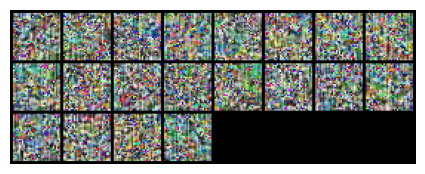

In [ ]:
from tqdm import tqdm
unet.eval()

fig = plt.figure(figsize=(10, 2))

img = torch.randn(20, 3, 32, 32).to(device)
T = noise_schedular.num_time_steps
for t_ in tqdm(range(T)):
  t = T - t_ - 1
  beta_t = noise_schedular.beta[t]
  alpha_t = noise_schedular.alpha[t]
  alpha_cumprod_t = noise_schedular.alpha_cumprod[t]

  with torch.no_grad():
    noise = unet(img, t)

  a = 1/torch.sqrt(alpha_t)
  b_ = torch.sqrt(1 - alpha_cumprod_t)
  b = beta_t/b_ if b_ != 0 else 0
  if t == 0:
    break
  img = a*(img - b*noise) + beta_t*torch.randn_like(img)


from torchvision.utils import make_grid

img = img*0.5 + 0.5
# print(img.max())
img = make_grid(img)
img = ToPILImage()(img)
# fig.add_subplot(1, 1, 1)
plt.axis("off")
plt.imshow(img)


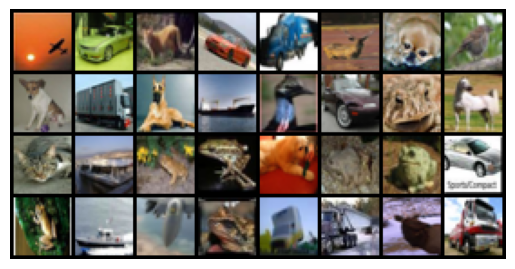

In [ ]:
images, _ = next(iter(loader))
images = images*0.5 + 0.5
grid = make_grid(images)
grid = ToPILImage()(grid)
plt.axis("off")
plt.imshow(grid)